In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from PIL import Image
import glob
import os

In [17]:
from topaz.utils.data.loader import load_image

# Walkthrough

This walkthrough gives a demo of using Topaz for particle picking with 30 micrographs from the EMPIAR-10025 dataset and a subset of the published particles simulating a small amount of manual labeling (50 particles per micrograph).

__Topaz is assumed to be installed in a conda environment named "topaz" for purposes of running topaz commands within bash cells.__ If topaz was installed in some other way, then the "source activate topaz" lines will need to be removed or changed below.

### Demo dataset

The tutorial dataset can be downloaded [here](http://bergerlab-downloads.csail.mit.edu/topaz/topaz-tutorial-data.tar.gz) and should be unpacked directly in this (the tutorial) directory.

```
wget http://bergerlab-downloads.csail.mit.edu/topaz/topaz-tutorial-data.tar.gz
tar -xzvf topaz-tutorial-data.tar.gz
```


### Design of the Topaz command line interface

Topaz is organized as a collection of command line tools for running different pieces of the particle picking pipeline. This design is to maximize customizability of the pipeline while also allowing the pipeline to be easily scripted and enable integration with other tools. To see a full list of the Topaz commands, run
```
topaz --help
```
on the command line. In this tutorial, we walk through the core components of the particle picking pipeline and illustrate their usage on the demo dataset.

# Preprocessing

In [3]:
%%bash
# we'll store the processed data in data/EMPIAR-10025/processed
# so we need to make these directories first
mkdir -p data/EMPIAR-10025/processed
mkdir -p data/EMPIAR-10025/processed/micrographs

### Micrograph downsampling and normalization
We first downsample the full micrographs 16x and then normalize them with the per-micrograph scaled Gaussian mixture model. For convenience, this can be performed in one step with the __'preprocess'__ command, but the two steps can also be run separately with the __'downsample'__ and __'normalize'__ commands.

This command takes the input MRC files and writes TIFF format output images to the data/EMPIAR-10025/processed/micrographs/ directory. Preprocessed micrographs can also be written in MRC, PNG, or some combination of MRC, TIFF, and PNG format. See

```
topaz preprocess --help
```

for more information on using the preprocess command.

__A note on downsampling:__ For this tutorial, we downsample 16x, but this may not always be the best downsampling amount for your data. We recommend downsampling your data enough that the diameter of your particle fits within the receptive field of the CNN architecture you are using. In this tutorial, we use the default architecture of resnet8, which has a receptive field size of 75 pixels. If you are using a different architecture, this number is slightly different: for conv31 the receptive field is 31 pixels and for conv63 the receptive field is 63 pixels.

As a rule of thumb, downsampling to about 4-8 Å per pixel generally works well, but this may need to be adjusted for very large or very small particles to fit the classifier as described above.

In [4]:
%%bash
source activate topaz
# to run the preprocess command, we pass the input micrographs as command line arguments
# preprocess will write the processed images to the directory specified with the -o argument
# -s sets the downsampling amount (in this case, we downsample by 16)
topaz preprocess -s16 -o data/EMPIAR-10025/processed/micrographs/ data/EMPIAR-10025/rawdata/micrographs/*.mrc

### Scale particle coordinates to match downsampled micrographs

For this tutorial, our demo dataset already contains a file containing training particle coordinates formatted in a tab delimited table that can be parsed by Topaz. To run Topaz on other datasets, some number of labeled particle coordinates will need to be provided in a compatible format. The training command (see next section) can accept the tab delimited table format and .star files. The __'convert'__ command can be  used to help convert between a wide range of file formats and also to rescale the coordinates to account for downsampling/upsampling. See
```
topaz convert --help
```
for more information.

Here, we use convert to scale our particle coordinates to match with the downsampling applied to the micrographs above.

In [5]:
%%bash
source activate topaz
# scale the particle coordinates to match the downsampling of the micrographs (factor is 1/16)

# this command takes the particle coordinates matched to the original micrographs
# and scales them by 1/16 (-s is downscaling)
# the -x option applies upscaling instead
topaz convert -s16 -o data/EMPIAR-10025/processed/particles.txt data/EMPIAR-10025/rawdata/particles.txt

### Examine the particle files (OPTIONAL)

Below, we just print the first few lines of the original particles.txt file and the processed particles.txt file. This shows the tab delimited coordinates file format and we can see that in the procssed file the coordinates have been downscaled by 16.

In [6]:
%%bash
head data/EMPIAR-10025/rawdata/particles.txt

image_name	x_coord	y_coord
14sep05c_c_00003gr_00014sq_00004hl_00004es_c	6924	2481
14sep05c_c_00003gr_00014sq_00004hl_00004es_c	5058	5578
14sep05c_c_00003gr_00014sq_00004hl_00004es_c	2932	1520
14sep05c_c_00003gr_00014sq_00004hl_00004es_c	2804	3587
14sep05c_c_00003gr_00014sq_00004hl_00004es_c	3763	6533
14sep05c_c_00003gr_00014sq_00004hl_00004es_c	4534	1173
14sep05c_c_00003gr_00014sq_00004hl_00004es_c	4239	818
14sep05c_c_00003gr_00014sq_00004hl_00004es_c	6934	4937
14sep05c_c_00003gr_00014sq_00004hl_00004es_c	4670	4865


In [7]:
%%bash
head data/EMPIAR-10025/processed/particles.txt

image_name	x_coord	y_coord
14sep05c_c_00003gr_00014sq_00004hl_00004es_c	433	155
14sep05c_c_00003gr_00014sq_00004hl_00004es_c	316	349
14sep05c_c_00003gr_00014sq_00004hl_00004es_c	183	95
14sep05c_c_00003gr_00014sq_00004hl_00004es_c	175	224
14sep05c_c_00003gr_00014sq_00004hl_00004es_c	235	408
14sep05c_c_00003gr_00014sq_00004hl_00004es_c	283	73
14sep05c_c_00003gr_00014sq_00004hl_00004es_c	265	51
14sep05c_c_00003gr_00014sq_00004hl_00004es_c	433	309
14sep05c_c_00003gr_00014sq_00004hl_00004es_c	292	304


# Model training

The core of Topaz is to _train_ a convolutional neural network to detect your particle using positive-unlabeled learning and then to _infer_ which micrograph regions contain particles using the trained classifier. We then _extract_ particles based on which regions are predicted to be particles.

The first part of this, training, requires us to specify which micrographs and labeled particle coordinates we want to use to train the model. Optionally, we can holdout some fraction of our data to _evaluate_ the model and determine how well the model is detecting particles that it was not trained on. We also need to specify a few hyperparameters, the key one being "--num-particles", the number of particles we expected there to be per micrograph.

To see all options for training models:
```
topaz train --help
```

### Required argument for training
--train-images={} <br/>
The directory containing the (processed) training micrographs or a file matching micrograph names (image_name) to the file path of that micrograph. This is required for Topaz to be able to find the training images and to correctly match the particle coordinates to the right micrograph. If you specify a directory, then topaz will look for your micrographs using the path: {director}/{image_name}.{tiff/mrc/png}

--train-targets={} <br/>
This is the path to the labeled training particle coordinates file.

-n/--num-particles {} <br/>
This is the expected number of particles per micrograph.

### Recommended optional arguments for training

__Holding out micrographs to evaluate the model (a test set)__ <br/>
--test-images={} <br/>
--test-targets={} <br/>
These parameters work identically to the --train equivalents and tell topaz to use these micrographs and particle coordinates to evaluate the model.

Alternatively, topaz can hold micrographs out from the training set _automatically_ using the following argument: <br/>
-k/--k-fold {} <br/>
This splits the training micrographs into _k_ groups and reserves _one_ of these groups for testing. In other words, it holds out _1/k_ micrographs (randomly) for evaluation.

__Model/training options__ <br/>
--model={} <br/>
This sets the model architecture. It is set to "resnet8" by default, but you may want to experiment with other options.

--radius={} <br/>
This sets how many micrograph regions around each particle coordinate are considered positive by assigning all regions with centers within _radius_ pixels to be positive regions. By default, this is set to 3. It is recommended to make this smaller than your particle radius, but not so small that there are very few positive regions per particle (unless you have _a lot_ of labeled coordinates (1000+)).

__Use background threads to help train faster and set which GPU to use__ <br/>
-d/--device {} <br/>
This sets which GPU (if there are multiple on your system) Topaz will use for training. It defaults to GPU 0. If you do not have a GPU, Topaz will use the CPU by default. To force Topaz to use the CPU, set this to -1.

--num-threads={} <br/>
The number of background threads to use for processing minibatches. By default, this is set to 0 which makes Topaz only use one thread. Especially when doing GPU training, setting this to be >1 (e.g. to 8) can dramatically speed up training.

### Specify where the training results and trained models should be saved
--save-prefix={} <br/>
This tells Topaz where to save the trained model. Topaz will save the model after every fixed number of parameter updates (determined by the --epoch-size argument) to a file named: {save_prefix}\_epoch{}.sav

-o/--output {} <br/>
Saves the training results (i.e. the training and test losses) to this file path.

## Split the data into train and test splits

For this tutorial, we assume the data is split into train and test sets, but, in general, _this step is optional_.

We holdout 10 micrographs with their associated labeled particles to evaluate the model on data not present during training. This allows us to get a measure of the model's ability to generalize to new micrographs. Heldout data can also be used for _model selection_. That is, we can use performance on heldout data to help choose the best value of $\pi$ and other training parameters, such as the model architecture.

In [8]:
%%bash
source activate topaz

## the topaz command "train_test_split" can be used to split a set of micrographs with their corresponding
## labeled particle coordinates into train and test sets
## we hold out 10 randomly chosen micrographs as the test set
## the train and test particle tables and image list tables will be written
## to the same directory as the input particle table
topaz train_test_split -n 10 --image-dir data/EMPIAR-10025/processed/micrographs/ \
                       data/EMPIAR-10025/processed/particles.txt

# splitting 30 micrographs with 1500 labeled particles into 20 train and 10 test micrographs
# writing: data/EMPIAR-10025/processed/particles_train.txt
# writing: data/EMPIAR-10025/processed/particles_test.txt
# writing: data/EMPIAR-10025/processed/image_list_train.txt
# writing: data/EMPIAR-10025/processed/image_list_test.txt


## Training a model on the demo data

In [9]:
%%bash
# first, make sure we have the folders where we want to put the saved models
# store the saved models in saved_models/EMPIAR-10025
mkdir -p saved_models
mkdir -p saved_models/EMPIAR-10025

In [10]:
%%bash
source activate topaz
# Now, we train the model
# We set -n 300 to tell Topaz that we expect there to be on average 300 particles per micrograph
# and --num-workers=8 to speed up training
# We'll evaluate the model on our test set held out in the previous section
topaz train -n 300 \
            --num-workers=8 \
            --train-images data/EMPIAR-10025/processed/image_list_train.txt \
            --train-targets data/EMPIAR-10025/processed/particles_train.txt \
            --test-images data/EMPIAR-10025/processed/image_list_test.txt \
            --test-targets data/EMPIAR-10025/processed/particles_test.txt \
            --save-prefix=saved_models/EMPIAR-10025/model \
            -o saved_models/EMPIAR-10025/model_training.txt

# Loading model: resnet8
# Model parameters: units=32, dropout=0.0, bn=on
# Receptive field: 71
# Using device=0 with cuda=True
# Loaded 20 training micrographs with 1000 labeled particles
# Loaded 10 test micrographs with 500 labeled particles
# source	split	p_observed	num_positive_regions	total_regions
# 0	train	0.00654	29000	4435200
# 0	test	0.00654	14500	2217600
# Specified expected number of particle per micrograph = 300.0
# With radius = 3
# Setting pi = 0.03923160173160173
# minibatch_size=256, epoch_size=5000, num_epochs=10
/data/cb/tbepler/workspace/topaz/topaz/methods.py:127: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q_discrete = F.softmax(q_discrete) # dim=0 doesn't work for pytorch=0.2.0
# Done!


### Examine the training results file
This is a table reporting the error during training. If heldout data was provided for evaluation, performance on the heldout data will be reported under "split" == "test".

In [11]:
training_results = pd.read_csv('saved_models/EMPIAR-10025/model_training.txt', sep='\t')
training_results.loc[training_results['split'] == 'test']

,epoch,iter,split,loss,ge_penalty,precision,tpr,fpr,auprc
5000,1,5001,test,0.043105,-,0.047164,0.200252,0.026627,0.07710950076580048
10001,2,10001,test,0.043152,-,0.062810,0.261643,0.025694,0.08537206798791885
15002,3,15001,test,0.043527,-,0.075145,0.294718,0.023873,0.09882136434316635
20003,4,20001,test,0.049989,-,0.071864,0.334850,0.028463,0.09684614092111588
25004,5,25001,test,0.049132,-,0.070742,0.310382,0.026834,0.08670441806316376
30005,6,30001,test,0.047364,-,0.075614,0.303444,0.024415,0.08856888115406036
35006,7,35001,test,0.054653,-,0.071000,0.334571,0.028812,0.08112957328557968
40007,8,40001,test,0.056362,-,0.073703,0.327078,0.027055,0.08004732429981232
45008,9,45001,test,0.066796,-,0.071993,0.383746,0.032557,0.08359844982624054
50009,10,50001,test,0.067654,-,0.072947,0.348606,0.029158,0.07511809468269348


#### Note about AUPRC (area under the precision-recall curve)
Because the test set is _partially_ labeled (i.e. only some particles are labeled as positives), the AUPR is an underestimate of the true AUPR, because the precision of the model is underestimated due to the unlabeled particles being considered negatives.

This means the AUPR for a test set is internally consistent - a model which has higher AUPR on the test set is picking better, but it is not comparable across datasets with different completeness of labeling.

# Particle extraction

Extract particles using an extraction radius of 7 pixels (-r7). This particle has diameter ~15 pixels in the downsampled micrographs, so using a radius of 7 prevents predicting multiple particle centers for a single particle.

In [12]:
%%bash

## make a directory to write the topaz particles to
mkdir -p data/EMPIAR-10025/topaz

In [15]:
%%bash
source activate topaz

## extract particle coordinates using the  trained model
## we set the radius parameter equal to 7 (-r 7)
## to prevent extracting particle coordinates closer than the radius of the particle
## i.e. we don't want multiple predictions for a single particle

topaz extract -r 7 -m saved_models/EMPIAR-10025/model_epoch10.sav \
              -o data/EMPIAR-10025/topaz/predicted_particles_all.txt \
              data/EMPIAR-10025/processed/micrographs/*.mrc

In [18]:
predicted_particles = pd.read_csv('data/EMPIAR-10025/topaz/predicted_particles_all.txt', sep='\t')
predicted_particles.head()

,image_name,x_coord,y_coord,score
0,14sep05c_c_00003gr_00014sq_00004hl_00004es_c,22,462,7.41612
1,14sep05c_c_00003gr_00014sq_00004hl_00004es_c,79,296,6.41252
2,14sep05c_c_00003gr_00014sq_00004hl_00004es_c,84,215,6.34325
3,14sep05c_c_00003gr_00014sq_00004hl_00004es_c,207,312,6.29326
4,14sep05c_c_00003gr_00014sq_00004hl_00004es_c,151,142,6.15442


### (OPTIONAL) Visualization of the prediction results
Given the particle coordinates and corresponding predicted scores above, we can visualize particles on a few micrographs held out in the test set.

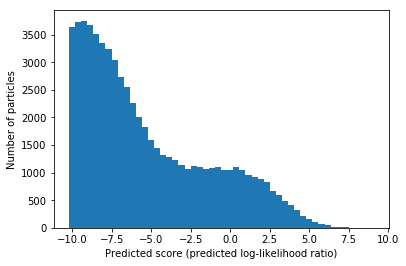

In [37]:
# plot the distribution of scores (predicted log-likelihood ratios)
_ = plt.hist(predicted_particles.score, bins=50)
plt.xlabel('Predicted score (predicted log-likelihood ratio)')
plt.ylabel('Number of particles')

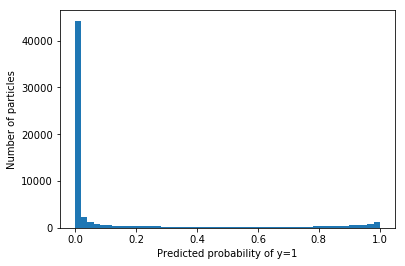

In [40]:
# plot predicted p(y=1|x) instead
proba = 1.0/(1.0 + np.exp(-predicted_particles.score))
_ = plt.hist(proba, bins=50)
plt.xlabel('Predicted probability of y=1')
plt.ylabel('Number of particles')

In [21]:
np.sum(predicted_particles.score >= 0) # how many particles are predicted with score >= 0

9391

In [22]:
## load the labeled particles
labeled_particles = pd.read_csv('data/EMPIAR-10025/processed/particles.txt', sep='\t')

In [27]:
## load the micrographs for visualization
micrographs = {}
for path in glob.glob('data/EMPIAR-10025/processed/micrographs/*.mrc'):
    im = np.array(load_image(path), copy=False)
    name,_ = os.path.splitext(os.path.basename(path))
    micrographs[name] = im

In [28]:
## load the train/test split so we can look at results on test set only!
images_train = pd.read_csv('data/EMPIAR-10025/processed/image_list_train.txt', sep='\t')
images_train = set(images_train.image_name)

images_test = pd.read_csv('data/EMPIAR-10025/processed/image_list_test.txt', sep='\t')
images_test = set(images_test.image_name)
image_names = list(images_test) # micrograph names for the test set

14sep05c_c_00007gr_00013sq_00009hl_00002es_c


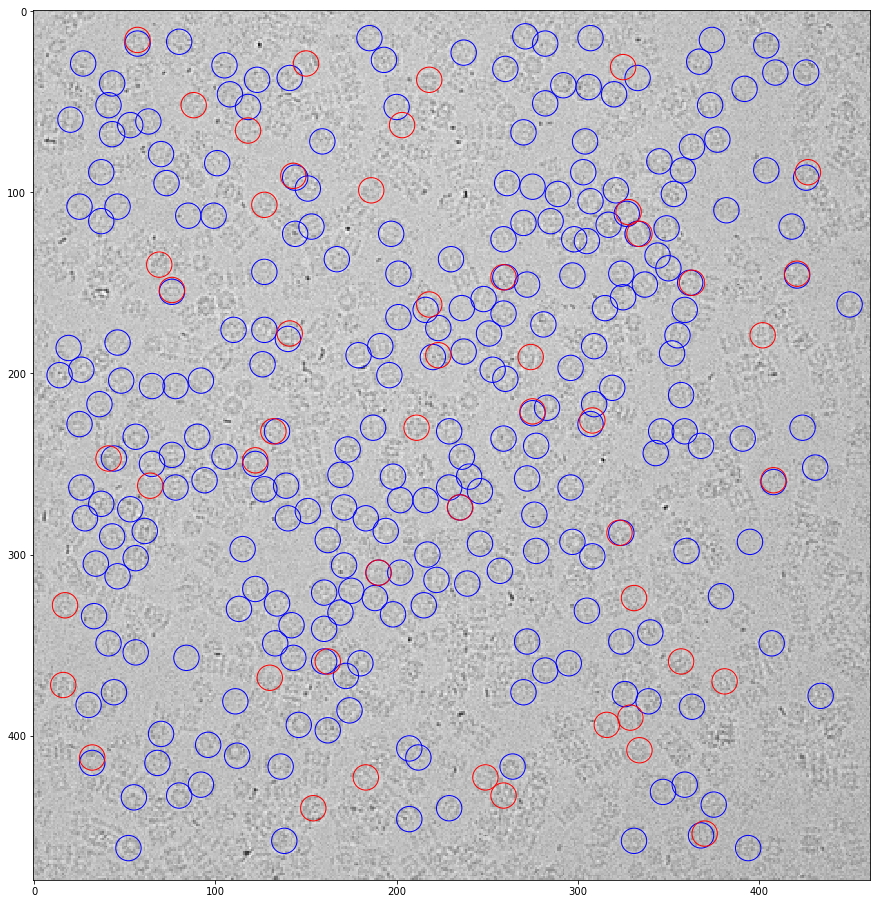

In [29]:
name = image_names[0]
print(name)
im = micrographs[name]
particles = predicted_particles.loc[predicted_particles['image_name'] == name]

# visualize predicted particles with log-likelihood ratio >= 0 (p >= 0.5)
# this may be too stringent for this dataset
particles = particles.loc[particles['score'] >= 0]


_,ax = plt.subplots(figsize=(16,16))
ax.imshow(im, cmap='Greys_r')

radius = 7

# plot the predicted particles in blue
for x,y in zip(particles.x_coord, particles.y_coord):
    c = Circle((x,y),radius,fill=False,color='b')
    ax.add_patch(c)
    
# plot the (partial) ground truth particles in red
ground_truth = labeled_particles.loc[labeled_particles['image_name'] == name]
for x,y in zip(ground_truth.x_coord, ground_truth.y_coord):
    c = Circle((x,y),radius,fill=False,color='r')
    ax.add_patch(c)


14sep05c_c_00004gr_00031sq_00010hl_00002es_c


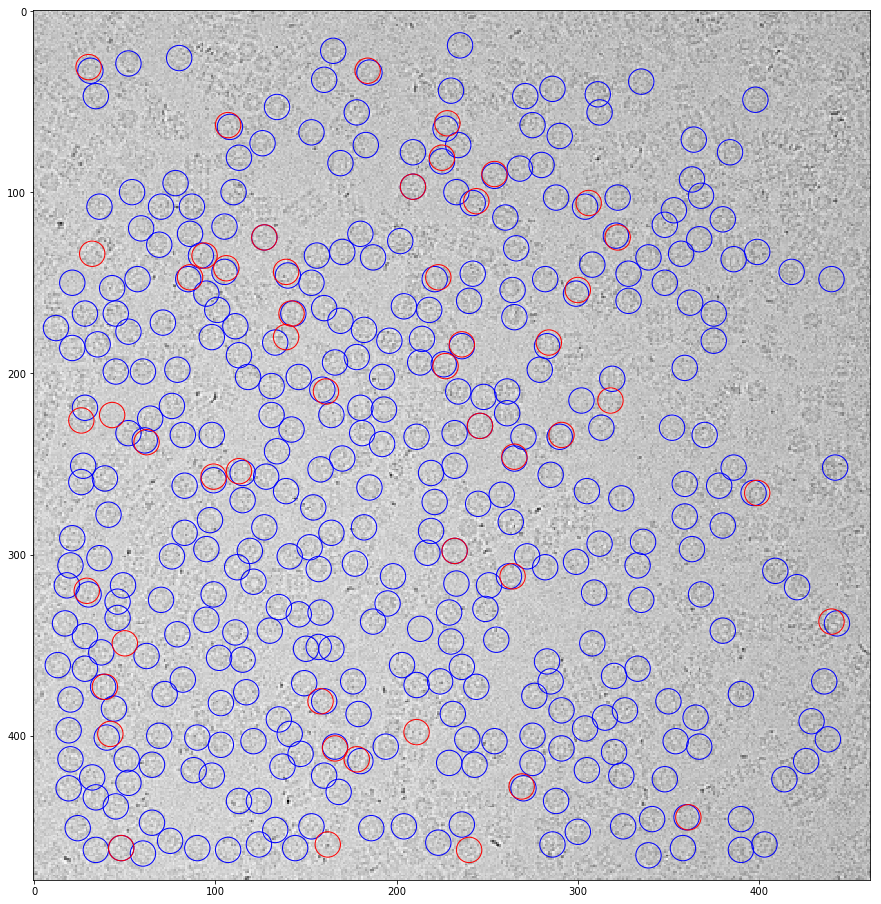

In [30]:
name = image_names[1]
print(name)
im = micrographs[name]
particles = predicted_particles.loc[predicted_particles['image_name'] == name]

# visualize predicted particles with log-likelihood ratio >= 0 (p >= 0.5)
# this may be too stringent for this dataset
particles = particles.loc[particles['score'] >= 0]


_,ax = plt.subplots(figsize=(16,16))
ax.imshow(im, cmap='Greys_r')

radius = 7

# plot the predicted particles in blue
for x,y in zip(particles.x_coord, particles.y_coord):
    c = Circle((x,y),radius,fill=False,color='b')
    ax.add_patch(c)
    
# plot the (partial) ground truth particles in red
ground_truth = labeled_particles.loc[labeled_particles['image_name'] == name]
for x,y in zip(ground_truth.x_coord, ground_truth.y_coord):
    c = Circle((x,y),radius,fill=False,color='r')
    ax.add_patch(c)


14sep05c_c_00007gr_00013sq_00008hl_00004es_c


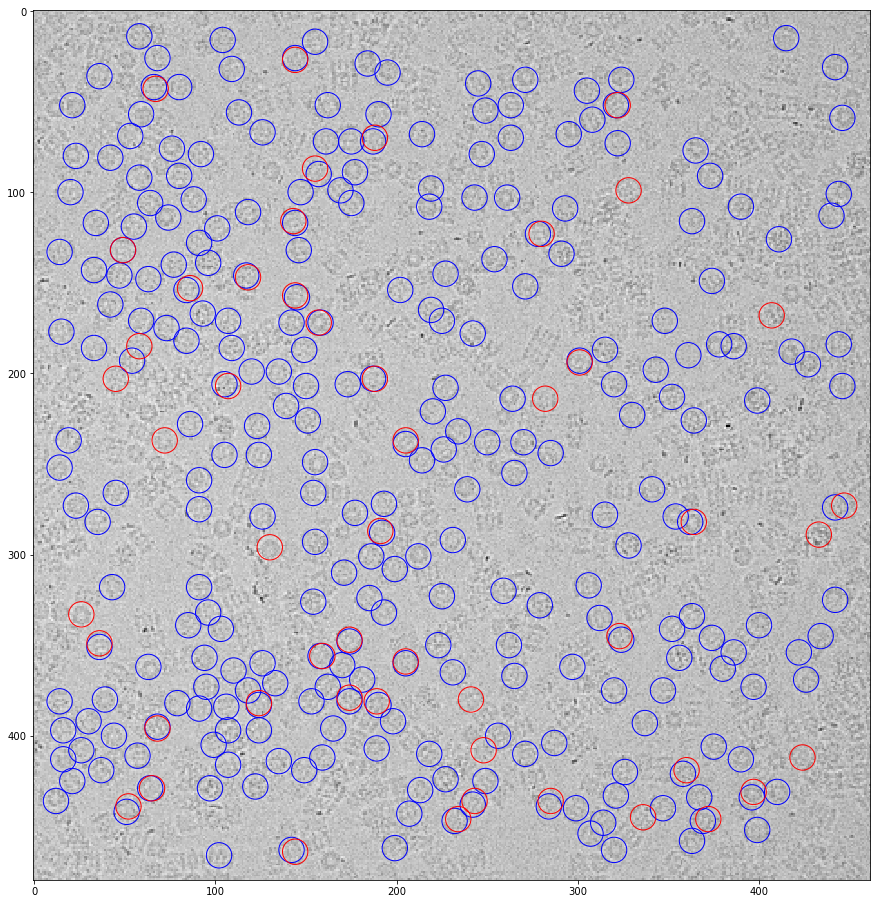

In [31]:
name = image_names[2]
print(name)
im = micrographs[name]
particles = predicted_particles.loc[predicted_particles['image_name'] == name]

# visualize predicted particles with log-likelihood ratio >= 0 (p >= 0.5)
# this may be too stringent for this dataset
particles = particles.loc[particles['score'] >= 0]


_,ax = plt.subplots(figsize=(16,16))
ax.imshow(im, cmap='Greys_r')

radius = 7

# plot the predicted particles in blue
for x,y in zip(particles.x_coord, particles.y_coord):
    c = Circle((x,y),radius,fill=False,color='b')
    ax.add_patch(c)
    
# plot the (partial) ground truth particles in red
ground_truth = labeled_particles.loc[labeled_particles['image_name'] == name]
for x,y in zip(ground_truth.x_coord, ground_truth.y_coord):
    c = Circle((x,y),radius,fill=False,color='r')
    ax.add_patch(c)


In [32]:
## visualize the top 100 predicted particles on the test set

n = 10
s = 31
panel = np.zeros((n*s, n*s), dtype=np.float32)

predicted_particles_test = predicted_particles.loc[predicted_particles.image_name.isin(images_test)]
predicted_particles_test = predicted_particles_test.sort_values('score', ascending=False)
for i in range(n):
    for j in range(n):
        k = i*n + j
        name = predicted_particles_test.iloc[k].image_name
        x_coord = predicted_particles_test.iloc[k].x_coord
        y_coord = predicted_particles_test.iloc[k].y_coord
        im = micrographs[name]
        
        xs = x_coord - s//2
        xe = xs + s
        ys = y_coord - s//2
        ye = ys + s
        
        pxs = j*s
        pxe = j*s+s
        pys = i*s
        pye = i*s+s
        
        if xs < 0:
            pxs -= xs
            xs = 0
        if xe > im.shape[1]:
            pxe -= xe - im.shape[1]
            xe = im.shape[1]
        if ys < 0:
            pys -= ys
            ys = 0
        if ye > im.shape[0]:
            pye -= ye - im.shape[0]
            ye = im.shape[0]
        
        panel[pys:pye,pxs:pxe] = im[ys:ye,xs:xe]

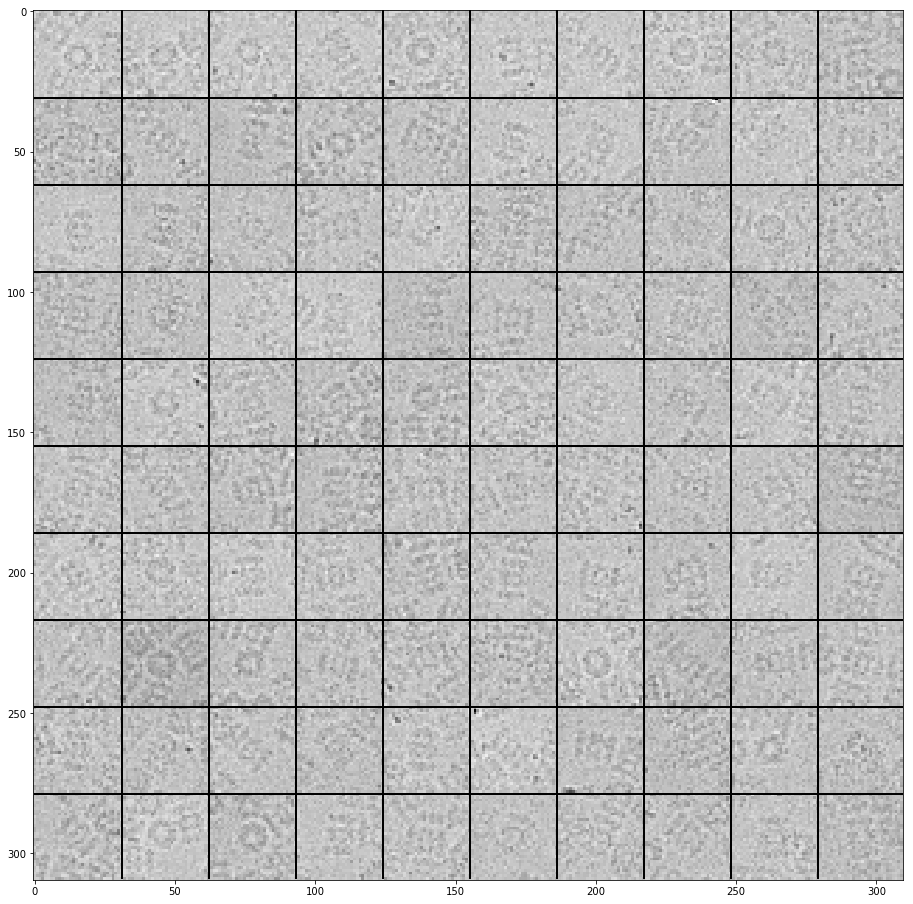

In [33]:
_,ax = plt.subplots(figsize=(16,16))
ax.imshow(panel, cmap='Greys_r')
for i in range(1,n):
    ax.plot([0,s*n-1],[i*s,i*s], 'k', linewidth=2)
    ax.plot([i*s,i*s],[0,s*n-1], 'k', linewidth=2)

As we can see, the model retrieves many more particles than are present in the incompletely labeled test set. The particles appear to be well centered and the top 100 particles show a nice mixture of side and top views.

## Generate MRC particle stack
Now that particles have been predicted, the particle coordinates can be scaled back up to the original (pre-downsampling) micrograph sizes. We provide utilities for converting the particle coordinates table to other file formats (.star, .box, .json) for compatability with downstream tools. We also provide a script for generating a .mrc file stack with corresponding .star file. 

In [34]:
%%bash
source activate topaz

# first, upsample the predicted particles back to original micrograph resolution

topaz convert -x 16 -o data/EMPIAR-10025/topaz/predicted_particles_all_upsampled.txt \
                            data/EMPIAR-10025/topaz/predicted_particles_all.txt

In [35]:
%%bash
source activate topaz

# here, we generate the particle stack using the predicted particles after upsamapling
# per-micrograph metadata (such as CTF parameters) can be optionally included in the 
# .star file generated with the particle stack

# --size specifies the dimensions of the particle crops
# --threshold specifies the score threshold above which to include particles in the stack
# --metadata is optional and in this case contains CTF parameters

# if output file is named "particles.mrc" then the .star file created will be "particles.star"

topaz particle_stack --image-root=data/EMPIAR-10025/rawdata/micrographs/ \
                     --size=400 \
                     --threshold=0 \
                     --metadata=data/EMPIAR-10025/rawdata/ctf_params.star \
                     -o data/EMPIAR-10025/topaz/predicted_particle_stack.mrcs \
                     data/EMPIAR-10025/topaz/predicted_particles_all_upsampled.txt

# Loaded 64855 particles
# Thresholding at 0.0
# Extracting 9391 particles
# 14sep05c_c_00003gr_00014sq_00004hl_00004es_c 346 particles
# 14sep05c_c_00003gr_00014sq_00005hl_00003es_c 293 particles
# 14sep05c_c_00003gr_00014sq_00007hl_00004es_c 278 particles
# 14sep05c_c_00003gr_00014sq_00011hl_00003es_c 306 particles
# 14sep05c_c_00003gr_00015sq_00015hl_00002es_c 324 particles
# 14sep05c_c_00003gr_00018sq_00008hl_00003es_c 309 particles
# 14sep05c_c_00003gr_00018sq_00010hl_00005es_c 283 particles
# 14sep05c_c_00003gr_00020sq_00011hl_00002es_c 341 particles
# 14sep05c_c_00003gr_00020sq_00011hl_00004es_c 358 particles
# 14sep05c_c_00004gr_00031sq_00002hl_00002es_c 261 particles
# 14sep05c_c_00004gr_00031sq_00005hl_00002es_c 354 particles
# 14sep05c_c_00004gr_00031sq_00010hl_00002es_c 363 particles
# 14sep05c_c_00004gr_00032sq_00007hl_00003es_c 361 particles
# 14sep05c_c_00004gr_00032sq_00010hl_00003es_c 297 particles
# 14sep05c_c_00004gr_00032sq_00029hl_00005es_c 247 particles
# 14sep05c

Done! Now we have a particle stack generated by picking with Topaz.

## Next steps

- To understand model selection and pricipled methods for choosing the score thresholds, take a look at the cross validation tutorial [here](https://github.com/tbepler/topaz/blob/master/tutorial/03_cross_validation.ipynb)